E-FRET Testing
==============

In [1]:
import numpy as np
from numpy import ma
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as anm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from skimage.util import montage
from skimage.filters import rank
from skimage import morphology
from skimage import exposure
from skimage import measure
from skimage import filters
from skimage import io

from scipy import ndimage
from scipy import signal
from scipy import stats

from dipy.align.transforms import AffineTransform2D
from dipy.align.imaffine import AffineRegistration

from domb.reg_type import wf_x2_m2 as WF

from domb.fret.e_fret import e_app

from domb.utils import plot
from domb.utils.plot import CMaps
from domb.utils import masking

In [2]:
img_path = '/home/wisstock/bio_data/chemLTD/24_03_14/'
raw_img = io.imread(img_path + '24_03_14_03.tif')

beads_img = io.imread(img_path + 'drift/24_03_14_beads_03.tif')

print(raw_img.shape)
print(beads_img.shape)

(42, 1040, 696, 4)
(2, 1040, 696)


## Registration

Optimizing level 2 [max iter: 10000]
Optimizing level 1 [max iter: 1000]
Optimizing level 0 [max iter: 100]


/home/wisstock/bio/scripts/domb-tools/src/domb/utils/masking.py:496: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


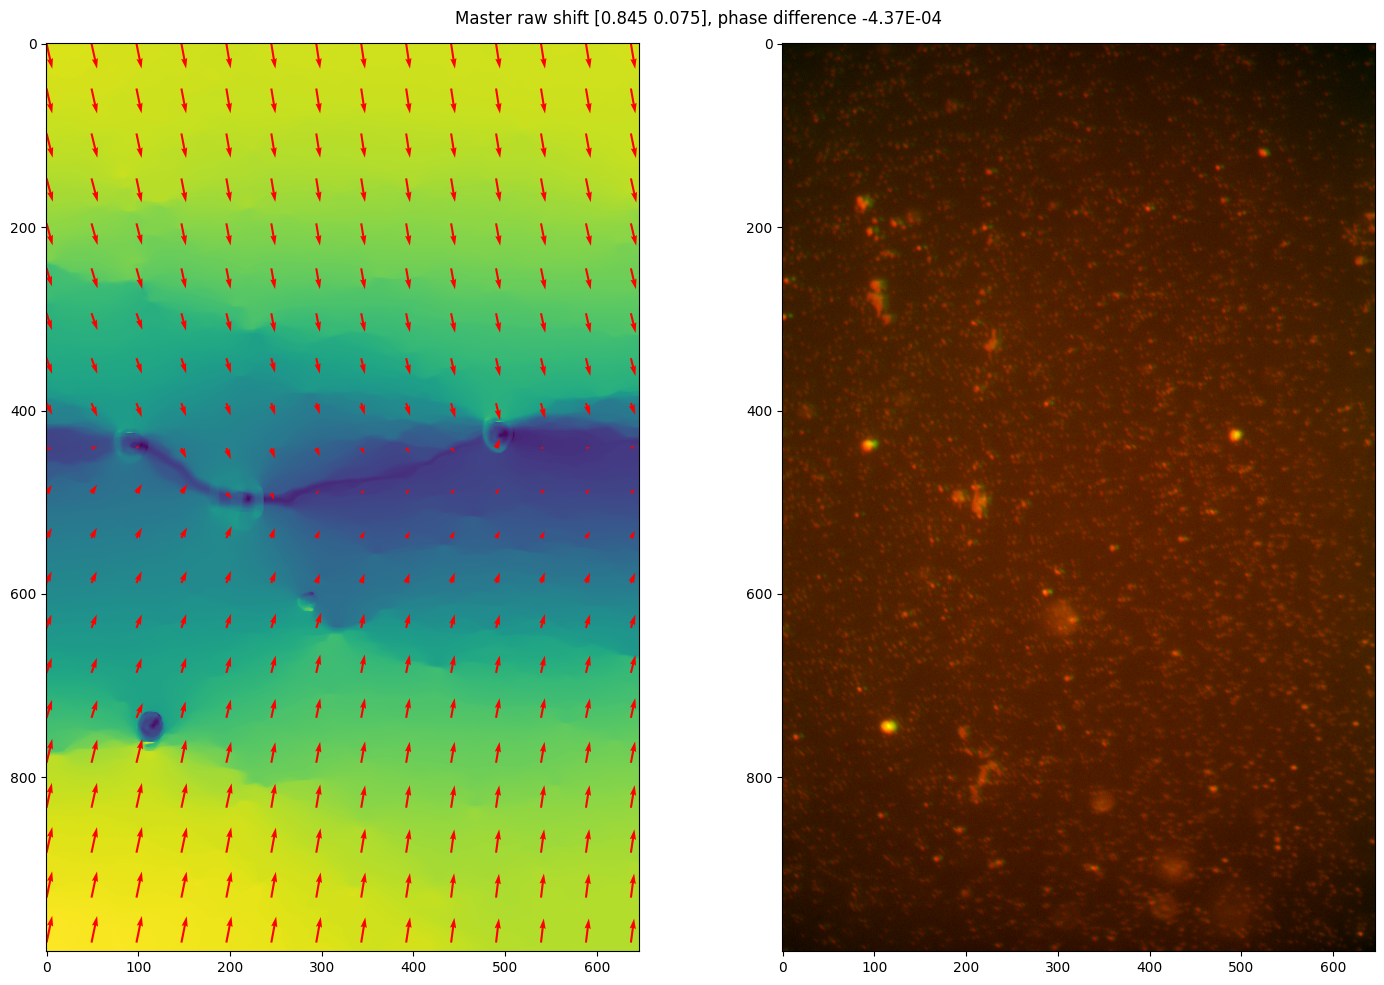

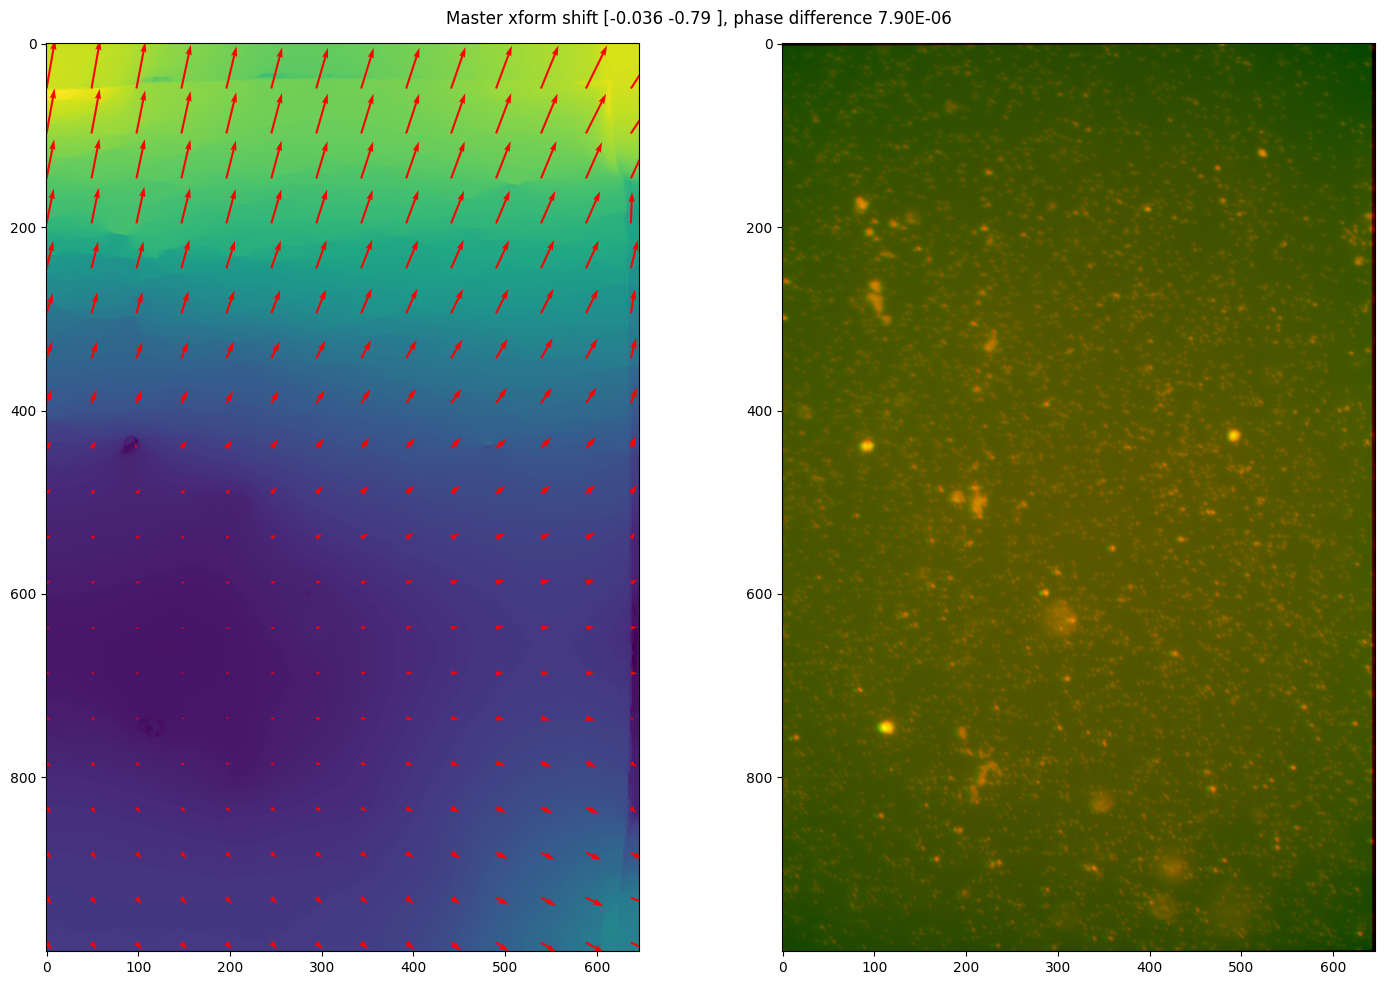

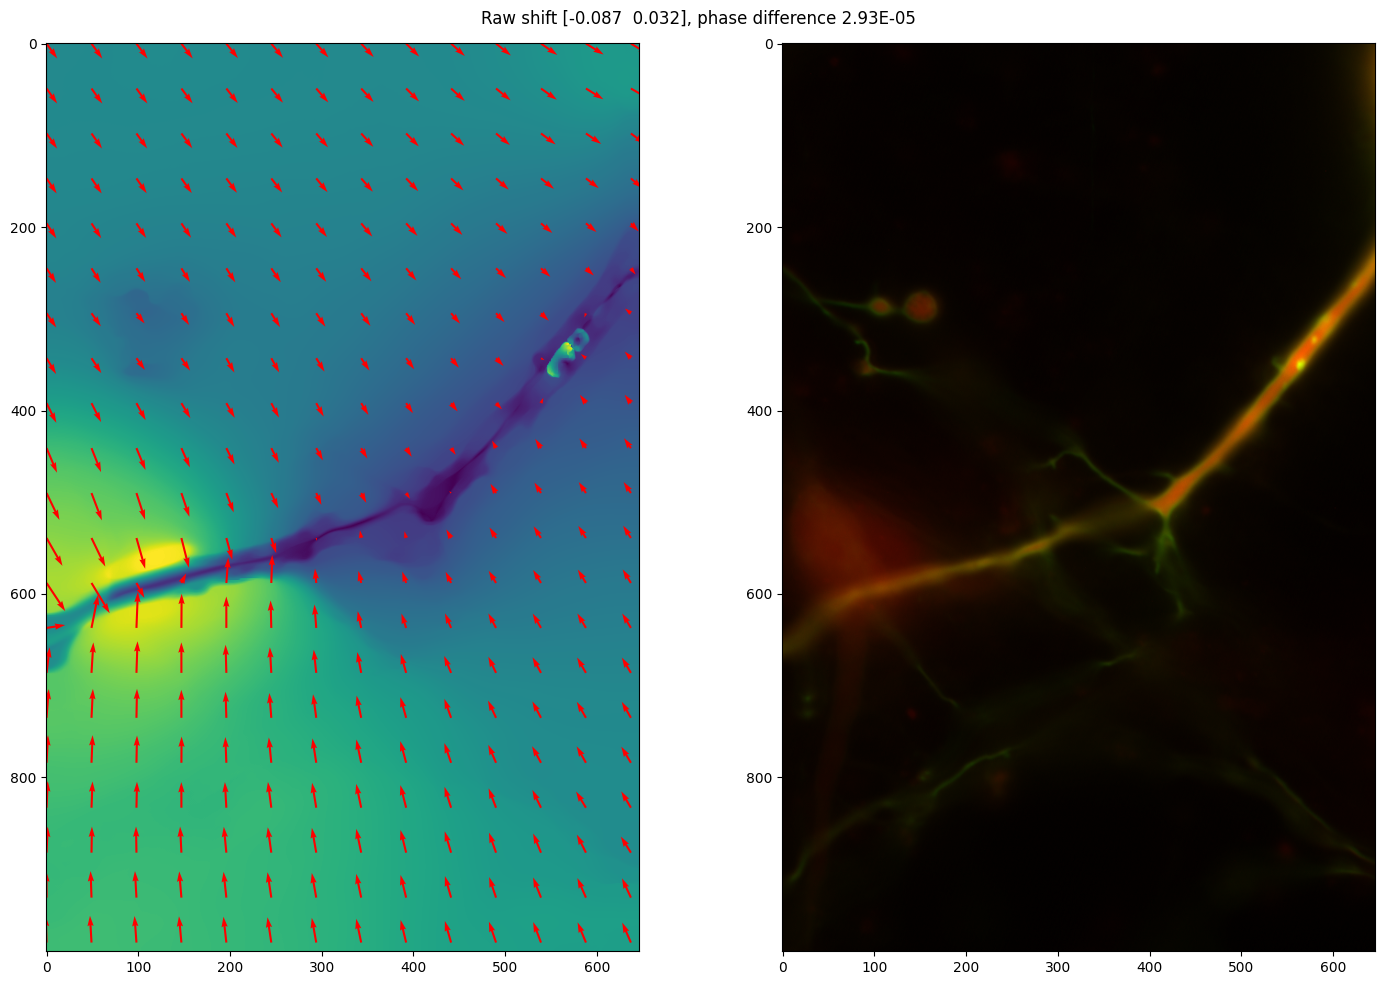

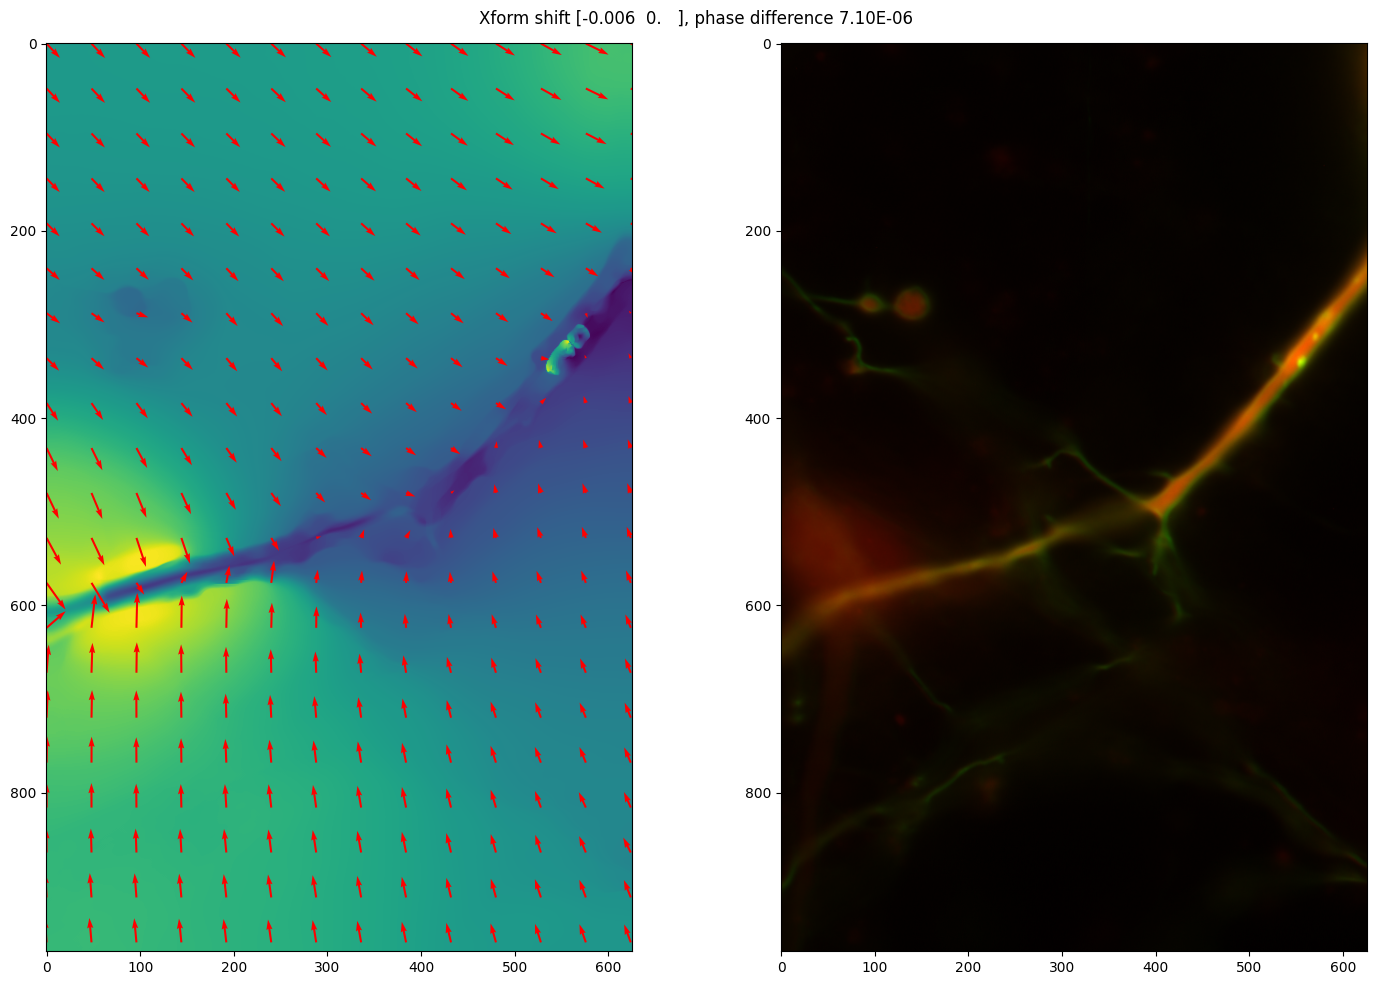

In [3]:
def restore_cfp_yfp(offset_series, master_img,
                   input_crop:int=15, output_crop:int=10):
    if offset_series.ndim == 4:
        if input_crop != 0:
            y, x = offset_series.shape[1:3]
            offset_series = offset_series[:,input_crop:y-input_crop,input_crop:x-input_crop,:]
            master_img = master_img[:,input_crop:y-input_crop,input_crop:x-input_crop]

        master_img_ref, master_img_offset = master_img[1], master_img[0]
        affreg = AffineRegistration()
        transform = AffineTransform2D()
        affine = affreg.optimize(master_img_ref, master_img_offset,
                                 transform, params0=None)
        master_img_xform = affine.transform(master_img_offset)

        masking.misalign_estimate(master_img_ref, master_img_offset,
                                  title='Master raw', show_img=True)
        masking.misalign_estimate(master_img_ref, master_img_xform,
                                  title='Master xform', show_img=True)
        masking.misalign_estimate(np.mean(offset_series[:,:,:,0], axis=0), np.mean(offset_series[:,:,:,-1], axis=0),
                                    title='Raw', show_img=True)

        ch0_xform = np.asarray([affine.transform(frame) for frame in offset_series[:,:,:,0]])
        ch2_xform = np.asarray([affine.transform(frame) for frame in offset_series[:,:,:,2]])
        xform_series = np.stack((ch0_xform, offset_series[:,:,:,1], ch2_xform, offset_series[:,:,:,3]),
                                axis=-1)
        if output_crop != 0:
            yo, xo = xform_series.shape[1:3]
            xform_series = xform_series[:,output_crop:yo-output_crop,output_crop:xo-output_crop,:]

        masking.misalign_estimate(np.mean(xform_series[:,:,:,0], axis=0), np.mean(xform_series[:,:,:,-1], axis=0),
                                    title='Xform', show_img=True)
    
        return xform_series.astype(offset_series.dtype)

    elif offset_series.ndim != 4:
        raise ValueError('Incorrect image shape!')
    
reg_img = restore_cfp_yfp(offset_series=raw_img, master_img=beads_img,
                          input_crop=25, output_crop=10)

(42, 970, 626, 4)


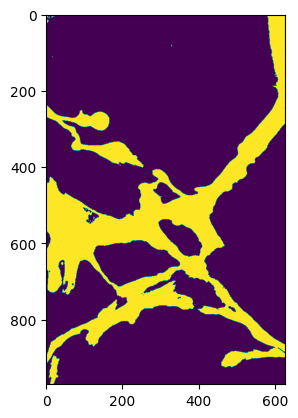

In [4]:
print(reg_img.shape)
mask = masking.proc_mask(np.mean(reg_img[:,:,:,3], axis=0))
plt.imshow(mask)

In [28]:
mask.shape

(970, 626)

shape:(42, 970, 626), type:uint16, min:247, perc:280.0, max:2754
shape:(42, 970, 626), type:float64, min:-69.0, perc:-35.0, max:2440.0


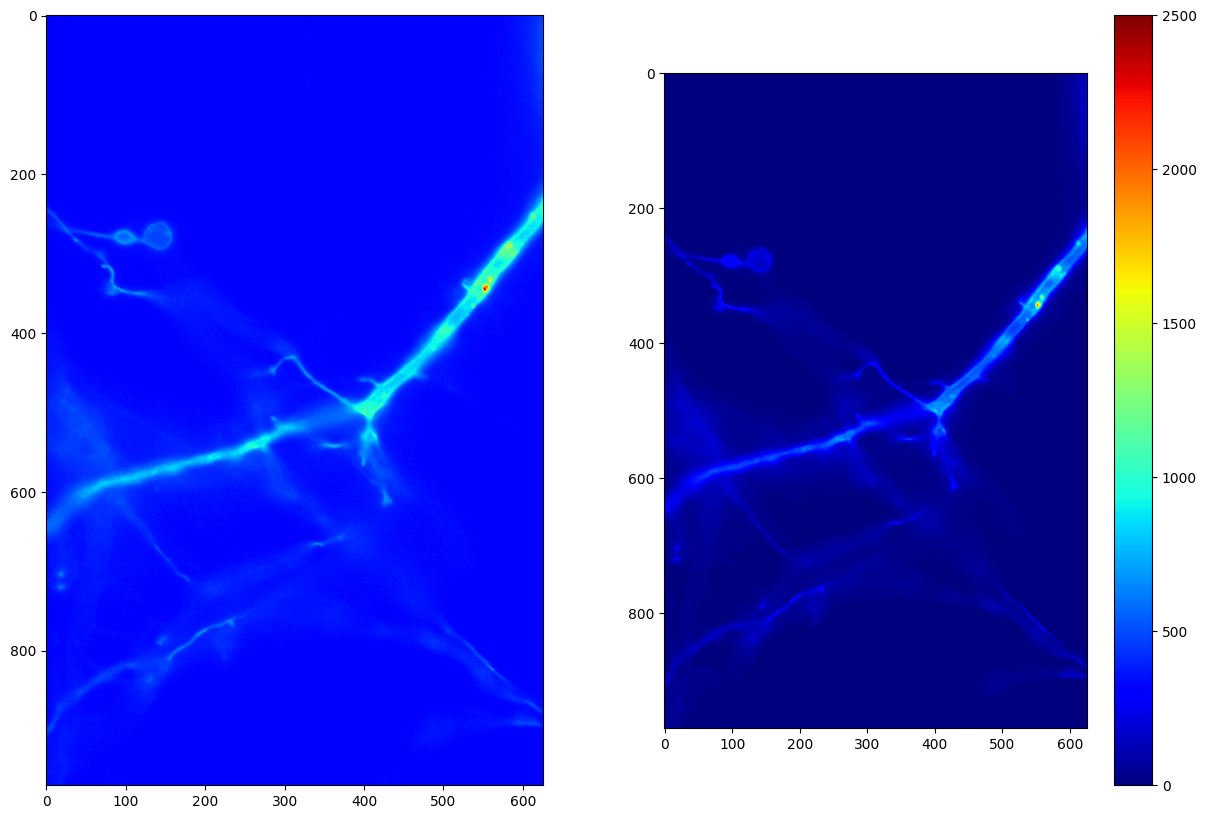

In [36]:
# bc_p_4d = lambda x: x - np.percentile(x, 1, axis=(1,2), keepdims=True).clip(min=0).astype(np.uint16)
bc_p_m = lambda x, m: np.array([f - np.percentile(f,50) for f in x])  #.clip(min=0).astype(np.uint16)

test = reg_img[...,-1]
print(f'shape:{test.shape}, type:{test.dtype}, min:{test.min()}, perc:{np.percentile(test, 1)}, max:{test.max()}')

test_bc = bc_p_m(test,mask)
print(f'shape:{test_bc.shape}, type:{test_bc.dtype}, min:{test_bc.min()}, perc:{np.percentile(test_bc, 1)}, max:{test_bc.max()}')

f_num, f_min, f_max = 0, 0, 2500
fig,ax = plt.subplots(ncols=2, figsize=(15,10))
ax[0].imshow(test[f_num], cmap='jet', vmin=f_min, vmax=f_max)
img = ax[1].imshow(test_bc[f_num], cmap='jet', vmin=f_min, vmax=f_max)
plt.colorbar(img)
plt.show()

In [29]:
test_bc.shape

(42, 970, 626)

## FRET

In [15]:
a=0.1489
b=0.1324
c=0.2481
d=0.8525
abcd = [a, b, c, d]
G = 5.5

reg_FRET = e_app.Eapp(dd_img=bc_p_m(reg_img[...,0], mask),
                      da_img=bc_p_m(reg_img[...,1], mask),
                      ad_img=bc_p_m(reg_img[...,2], mask),
                      aa_img=bc_p_m(reg_img[...,3], mask),
                      abcd_list=abcd, G_val=G,
                      mask=mask, corr_by_mask=True)  # parameters for E_corr_calc

# _,conn_fret = masking.label_prof_arr(input_label=input_RG.connected_up_label,
#                                    input_img_series=input_FRET.Ecorr_img)
# _,halo_fret = masking.label_prof_arr(input_label=input_RG.halo_up_label, 
#                                    input_img_series=input_FRET.Ecorr_img)
# _,init_fret = masking.label_prof_arr(input_label=input_RG.init_up_label,
#                                    input_img_series=input_FRET.Ecorr_img)

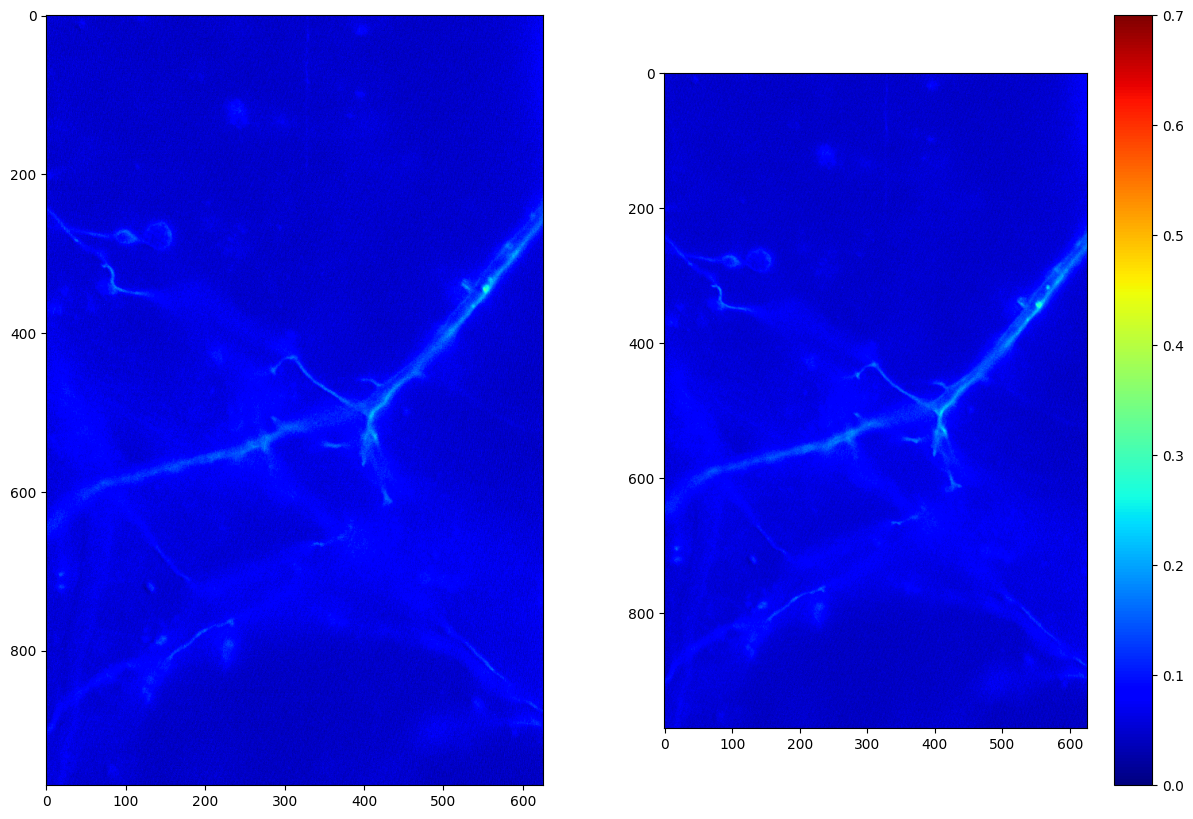

In [16]:
fig,ax = plt.subplots(ncols=2, figsize=(15,10))
ax[0].imshow(reg_FRET.Ecorr_img[0], cmap='jet', vmin=0, vmax=0.7)
img = ax[1].imshow(reg_FRET.Ecorr_img[7], cmap='jet', vmin=0, vmax=0.7)
plt.colorbar(img)
plt.show()

In [ ]:
plot.stat_line_plot(arr_list=[conn_fret,
                              halo_fret,
                              init_fret],
                    lab_list=['conn', 'halo', 'init'],
                    stat_method='ci', stim_t=8,
                    figsize=(10,4), x_lab='Time, s', y_lab='Eapp', plot_title='Eapp profiles')

### FRET masking

In [ ]:
max_fret = reg_FRET.Ecorr_img[-1]

fret_mask = max_fret > filters.threshold_otsu(ma.masked_where(~reg.proc_mask, max_fret).compressed())
# fret_mask = max_fret > filters.threshold_otsu(max_fret)
fret_mask[~reg.proc_mask] = 0
fret_mask = morphology.opening(fret_mask, footprint=morphology.disk(3))

plt.imshow(fret_mask)
plt.show()

_,fret_fret = masking.label_prof_arr(input_label=measure.label(fret_mask),
                                   input_img_series=reg_FRET.Ecorr_img)

plot.stat_line_plot(arr_list=[fret_fret],
                    lab_list=['FRET mask'],
                    stat_method='se',
                    figsize=(10,4))

## dF vs. FRET

In [ ]:
time_line = np.linspace(0, wt_mean.shape[0]*2, \
                            num=wt_mean.shape[0])

df_profiles = pd.DataFrame(columns=['ID', 'ROI', 'mask', 'time', 'type', 'int'])

delta = lambda f, f_0: (f - f_0)/f_0
vdelta = np.vectorize(delta)

# for roi_num in np.unique(reg_RG.connected_up_label)[1:]:
#     roi_mask = reg_RG.connected_up_label == roi_num
#     wt_prof = np.mean(reg.corr_fp1_img, axis=(1,2), where=roi_mask)
#     wt_prof = vdelta(np.mean(wt_prof[:5]), wt_prof)
#     mut_prof = np.mean(reg.corr_fp2_img, axis=(1,2), where=roi_mask)
#     mut_prof = vdelta(np.mean(mut_prof[:5]), mut_prof)
#     fret_prof = np.mean(reg_FRET.Ecorr_img, axis=(1,2), where=roi_mask)
#     df = pd.DataFrame({'ID':np.full(wt_prof.shape[0]*3, reg.img_name),
#                             'ROI':np.full(wt_prof.shape[0]*3, roi_num),
#                             'mask':np.full(wt_prof.shape[0]*3, 'conn'),
#                             'time':np.concatenate((time_line, time_line, time_line)),
#                             'type':np.concatenate((np.full(wt_prof.shape[0], 'WT'),
#                                                    np.full(wt_prof.shape[0], 'N75K'),
#                                                    np.full(wt_prof.shape[0], 'FRET'))),
#                             'int':np.concatenate((wt_prof, mut_prof, fret_prof))})
#     df_profiles = pd.concat([df_profiles, df], ignore_index=True)

# for roi_num in np.unique(reg_RG.init_up_label)[1:]:
#     roi_mask = reg_RG.connected_up_label == roi_num
#     wt_prof = np.mean(reg.corr_fp1_img, axis=(1,2), where=roi_mask)
#     wt_prof = vdelta(np.mean(wt_prof[:5]), wt_prof)
#     mut_prof = np.mean(reg.corr_fp2_img, axis=(1,2), where=roi_mask)
#     mut_prof = vdelta(np.mean(mut_prof[:5]), mut_prof)
#     fret_prof = np.mean(reg_FRET.Ecorr_img, axis=(1,2), where=roi_mask)
#     df = pd.DataFrame({'ID':np.full(wt_prof.shape[0]*3, reg.img_name),
#                             'ROI':np.full(wt_prof.shape[0]*3, roi_num),
#                             'mask':np.full(wt_prof.shape[0]*3, 'init'),
#                             'time':np.concatenate((time_line, time_line, time_line)),
#                             'type':np.concatenate((np.full(wt_prof.shape[0], 'WT'),
#                                                    np.full(wt_prof.shape[0], 'N75K'),
#                                                    np.full(wt_prof.shape[0], 'FRET'))),
#                             'int':np.concatenate((wt_prof, mut_prof, fret_prof))})
#     df_profiles = pd.concat([df_profiles, df], ignore_index=True)

for roi_num in np.unique(reg_RG.halo_up_label)[1:]:
    roi_mask = reg_RG.connected_up_label == roi_num
    wt_prof = np.mean(reg.corr_fp1_img, axis=(1,2), where=roi_mask)
    wt_prof = vdelta(wt_prof, np.mean(mut_prof[:5]))
    mut_prof = np.mean(reg.corr_fp2_img, axis=(1,2), where=roi_mask)
    mut_prof = vdelta(mut_prof, np.mean(mut_prof[:5]))
    fret_prof = np.mean(reg_FRET.Ecorr_img, axis=(1,2), where=roi_mask)
    df = pd.DataFrame({'ID':np.full(wt_prof.shape[0]*3, reg.img_name),
                            'ROI':np.full(wt_prof.shape[0]*3, roi_num),
                            'mask':np.full(wt_prof.shape[0]*3, 'halo'),
                            'time':np.concatenate((time_line, time_line, time_line)),
                            'type':np.concatenate((np.full(wt_prof.shape[0], 'WT'),
                                                   np.full(wt_prof.shape[0], 'N75K'),
                                                   np.full(wt_prof.shape[0], 'FRET'))),
                            'int':np.concatenate((wt_prof, mut_prof, fret_prof))})
    df_profiles = pd.concat([df_profiles, df], ignore_index=True)

df_profiles

In [ ]:
fig = px.line(df_profiles, x='time', y='int', color='mask',
              line_dash='type', animation_frame='ROI')
fig.show()

In [ ]:
arr_se_stat = lambda x: (np.mean(x, axis=0), \
                         np.std(x, axis=0)/np.sqrt(x.shape[1]))

wt_mean, wt_var = arr_se_stat(reg_RG.wt_conn_df_arr) 
mut_mean, mut_var = arr_se_stat(reg_RG.mut_conn_df_arr)

fret_mean, fret_var = arr_se_stat(conn_fret)


time_line = np.linspace(0, wt_mean.shape[0]*2, \
                            num=wt_mean.shape[0])

fig, ax1 = plt.subplots(figsize=(10,5))

ax1.errorbar(time_line, wt_mean,
             yerr = wt_var,
             fmt ='-o', color='k', capsize=4, label='WT')
ax1.errorbar(time_line, mut_mean,
             yerr = mut_var,
             fmt ='-o', color='r', capsize=4, label='N75K')
ax1.set_xlabel('Time, s')
ax1.set_ylabel('ΔF/F', color='r')
ax1.tick_params(axis ='y', labelcolor='r')
ax1.hlines(y=0, xmin=0, xmax=time_line.max(), linestyles='--', color='k')
ax1.axvline(x=10, color='k', linestyle=':', label='Glu application')

plt.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.errorbar(time_line, fret_mean*100,
             yerr = fret_var*100,
             fmt ='-o', color='b', capsize=4, label='FRET')
ax2.set_ylim([0,20])
ax2.set_ylabel('E app, %', color='b')
ax2.tick_params(axis ='y', labelcolor='b')

plt.legend(loc='lower left')
plt.tight_layout()
plt.title('Connected')
plt.show()

## OLD STAT

#### Max amp stat

In [ ]:
wt_amp_prof = cfp_dist_prof_arr_con_mask
mut_amp_prof = yfp_dist_prof_arr_con_mask

max_frame = 10

wt_max_amp = wt_amp_prof[:, max_frame]
mut_max_amp = mut_amp_prof[:, max_frame]

print(len(wt_max_amp), len(mut_max_amp))

amp_u_test = stats.mannwhitneyu(wt_max_amp, mut_max_amp)
print(f"U-test p-val={round(amp_u_test[1], 5)}")


wt_amp_df = pd.DataFrame({'FP':np.full(len(wt_max_amp), 'WT'),
                           'amp':wt_max_amp})
mut_amp_df = pd.DataFrame({'FP':np.full(len(mut_max_amp), 'N75K'),
                           'amp':mut_max_amp})
amp_df = pd.concat([wt_amp_df, mut_amp_df], ignore_index=True)


fig = px.box(amp_df, x='FP', y='amp', color='FP', points='all',
             title=f'<b>U-test p={round(amp_u_test[1], 3)}</b>',
             labels={"amp": "<b>ΔF/F</b>", "FP": ""},
             color_discrete_sequence=['#000000', '#ff0000'])
fig.update_layout(height=600, width=300, showlegend=False,
                  margin={'l':0, 'r':10, 't':50, 'b':0},
                  font={"size":15, "color":"#000000"},  # "family":"Nunito", 
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.update_yaxes(ticks='inside',
                 showline=False,
                 gridcolor='grey')
fig.show()

#### Area stat

In [ ]:
def area_calc(input_labels):
    input_props = measure.regionprops(input_labels)
    output_areas = []
    for reg_prop in input_props:
        output_areas.append(reg_prop.area)

    return output_areas


wt_up_areas = area_calc(connected_up_label)
mut_up_areas = area_calc(mutant_up_label)

print(len(wt_up_areas), len(mut_up_areas))

area_u_test = stats.mannwhitneyu(wt_up_areas, mut_up_areas)
print(f"U-test p-val={round(area_u_test[1], 5)}")


wt_area_df = pd.DataFrame({'FP':np.full(len(wt_up_areas), 'WT'),
                           'area':wt_up_areas})
mut_area_df = pd.DataFrame({'FP':np.full(len(mut_up_areas), 'N75K'),
                           'area':mut_up_areas})
area_df = pd.concat([wt_area_df, mut_area_df], ignore_index=True)


fig = px.box(area_df, x='FP', y='area', color='FP', points='all',
             title=f'<b>U-test p={round(area_u_test[1], 3)}</b>',
             labels={"area": "<b>ROIs area, px</b>", "FP": ""},
             color_discrete_sequence=['#000000', '#ff0000'])
fig.update_layout(height=600, width=300, showlegend=False,
                  margin={'l':0, 'r':10, 't':50, 'b':0},
                  font={"size":15, "color":"#000000"},  # "family":"Nunito", 
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.update_yaxes(ticks='inside',
                 showline=False,
                 gridcolor='grey')
fig.show()